# Descriptive (Spatial) Analytics - Idle Time

To account for large time gaps when the driver does not work, we introduce a threshold of xx to consider only significant idle periods. In the following we present the steps we followed to calculate the average idle time:

1. **Sorting the Trips in ascending order for each taxi:** We sort the trips in ascending order for each taxi and start time.

2. **Identifying the Idle Periods:** For each driver, we find the time gap between the end time of one trip and the start time of the next trip. 

3. **Introducing a threshold of xx hours:** If the time gap exceeds the defined threshold of xx minutes (i.e., xx hours), we can ignore this time gaps, because the driver is not working at that time. By introducing a threshold, you can exclude the large time gaps when the driver does not work from the calculation of the average idle time. This approach provides a more accurate representation of the idle time during active working periods.

4. **Summing Idle Times up:** We add up all the significant idle times calculated after step 3 for all drivers to get the total idle time.

5. **Counting the Idle Periods:** We count the number of significant idle periods observed in step 2. This will be the total number of significant idle periods for all drivers.

6. **Calculating the Average:** We divide the total idle time by the number of significant idle periods to find the average idle time per significant idle period.


In [69]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from h3 import h3

import descriptive as desc

In [2]:
# import datasets
df_chicago = pd.read_csv("..\data\datasets\df_chicago.csv.zip")

In [3]:
#prepare later needed features and variables
df_chicago["Trip_Minutes"] = np.floor(df_chicago["Trip_Seconds"] / 60)
df_chicago["Pickup_C->Dropoff_C"] = df_chicago["Pickup_Census_Tract"].astype(str)+"->"+df_chicago["Dropoff_Census_Tract"].astype(str)

palette = "turbo"

In [4]:
# Sort trip data by start time
df = df_chicago.sort_values(by=['Taxi_ID', 'Original_Trip_Start_Timestamp'])

# Reset index
df.reset_index(drop=True, inplace=True)

# defining a threshold in minutes
threshold_minutes = 300 # 6 hours

# Calculate time differences using vectorized operations
time_diff = (
    pd.to_datetime(df["Original_Trip_Start_Timestamp"]) -
    pd.to_datetime(df["Original_Trip_End_Timestamp"].shift())
).dt.total_seconds() / 60

# Set "Idle Time Minutes" column based on the threshold
df["Idle Time Minutes"] = np.where(
    (time_diff > threshold_minutes) & 
    (df["Taxi_ID"] == df["Taxi_ID"].shift()), time_diff, 0)

# Set "Idle Period" column based on condition using np.where
df["Idle Period"] = np.where(
    (df["Idle Time Minutes"] < threshold_minutes) &
    (df["Taxi_ID"] == df["Taxi_ID"].shift()),
    1, 0
)

# Set "Idle Time Minutes" column based on the threshold
df["Idle Time Minutes"] = np.where(
    (time_diff <= threshold_minutes) &
    (df["Taxi_ID"] == df["Taxi_ID"].shift()), time_diff, 0)

df.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,Trip_Minutes,Pickup_C->Dropoff_C,Idle Time Minutes,Idle Period
0,7c5f446862febec7ff725c9dbfda3f53d2b58cff,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2013-07-12 16:00:00,2013-07-12 16:00:00,1560.0,6.0,NaN,NaN,6.0,15.0,...,59.0,3.0,sky is clear,882664c163fffff,872664c16ffffff,862664c17ffffff,26.0,nan->nan,0.0,0
1,106f37011cf2e3a4164bb03a8e33f8a77ad2b31b,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2013-07-12 19:00:00,2013-07-12 19:00:00,1620.0,5.8,1.703183e+10,1.703108e+10,6.0,8.0,...,63.0,4.0,sky is clear,882664c161fffff,872664c16ffffff,862664c17ffffff,27.0,17031832000.0->17031081500.0,165.0,1
2,7797e40db82db8850c092c84b3f2c3b8fec632b1,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2013-07-12 20:00:00,2013-07-12 20:00:00,1200.0,3.8,1.703108e+10,1.703124e+10,8.0,24.0,...,0.0,4.0,sky is clear,882664c1e1fffff,872664c1effffff,862664c1fffffff,20.0,17031081201.0->17031241400.0,15.0,1
3,28fc5c3b06a7096764752e5b73e9451c7b96b5ee,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2013-07-12 20:00:00,2013-07-12 20:00:00,720.0,3.1,1.703124e+10,1.703107e+10,24.0,7.0,...,0.0,4.0,sky is clear,882664cac3fffff,872664cacffffff,862664cafffffff,12.0,17031242200.0->17031071500.0,0.0,1
4,c51e93e5ce3e49ff3507992843e4c1998eb60a5f,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2013-07-13 14:00:00,2013-07-13 14:00:00,480.0,1.4,NaN,NaN,31.0,28.0,...,17.0,1.0,sky is clear,882664cf61fffff,872664cf6ffffff,862664cf7ffffff,8.0,nan->nan,0.0,0


In [5]:
average_idle_time = df["Idle Time Minutes"].sum() / df["Idle Period"].sum()
print("The average idle time with a threshold value of",threshold_minutes,"minutes is: ",round(average_idle_time, 2))

The average idle time with a threshold value of 300 minutes is:  33.2


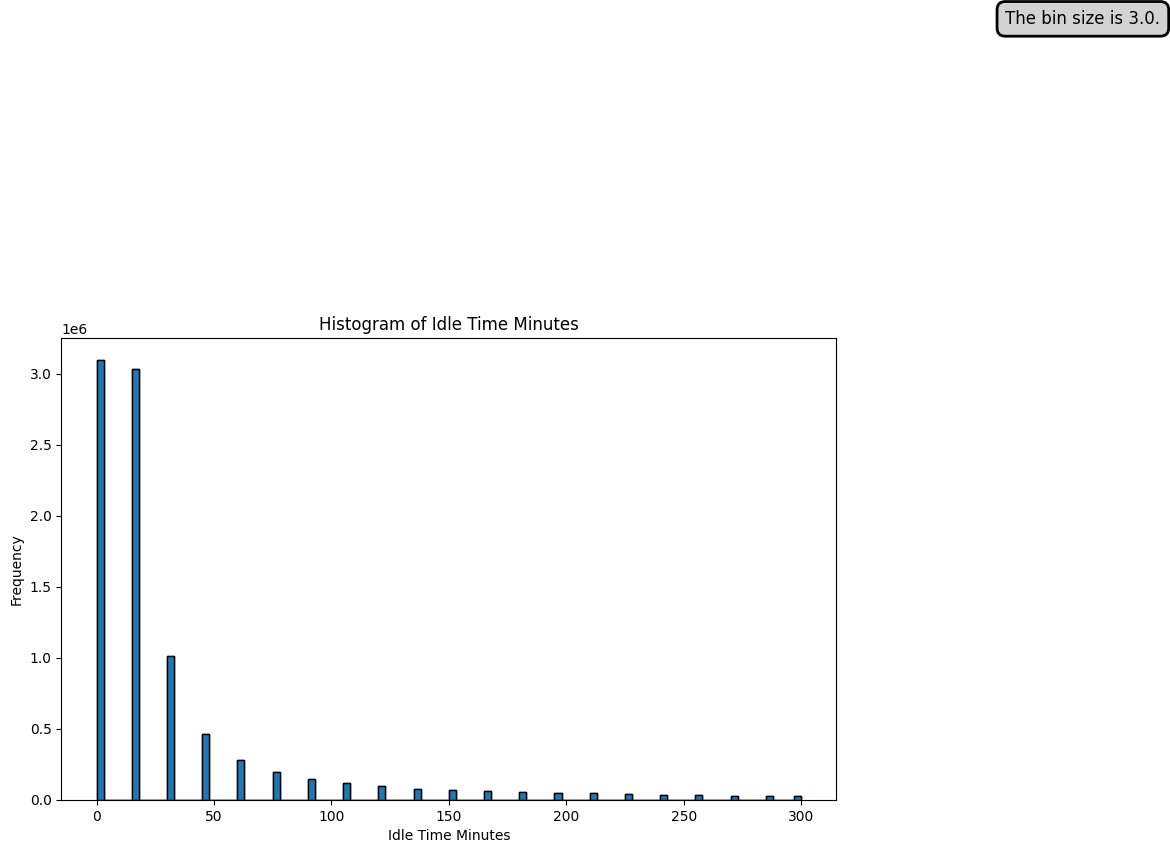

In [6]:
# Assuming df["Idle Time Minutes"] is a numeric column
idle_time_minutes = df["Idle Time Minutes"]

# Set the figure size (width, height) in inches
plt.figure(figsize=(10, 6))

# Plot the histogram and get bin edges
hist, bin_edges, _ = plt.hist(idle_time_minutes, bins=100, edgecolor='black', align='mid')

# Calculate the center positions of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the bin intervals
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), align='center', edgecolor='black')

plt.xlabel("Idle Time Minutes")
plt.ylabel("Frequency")
plt.title("Histogram of Idle Time Minutes")

# Add a border around the note
border_props = dict(boxstyle='round, pad=0.5', fc='lightgray', ec='black', lw=2)

# Add the note with the specified coordinates and border properties
plt.text(420, 5.5e6, f"The bin size is {bin_edges[1] - bin_edges[0]}.", fontsize=12, ha='center', va='center', color='black', bbox=border_props)

plt.show()


### Census Tract

In [7]:
# How many idle minutes were gathered per pickup census tract in total
grouped = df[["Pickup_Census_Tract", "Idle Time Minutes"]].groupby("Pickup_Census_Tract").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 17031010100.0 with:  0.0
Lowest values in: 17031100600.0 with:  0.0
Lowest values in: 17031150800.0 with:  0.0
Lowest values in: 17031151001.0 with:  0.0
Lowest values in: 17031161300.0 with:  0.0
Highest values in: 17031081403.0 with:  7020135.0
Highest values in: 17031081700.0 with:  10176075.0
Highest values in: 17031081500.0 with:  11412000.0
Highest values in: 17031320100.0 with:  14081880.0
Highest values in: 17031839100.0 with:  22400790.0


In [8]:
# How many idle minutes were gathered per dropoff census tract in total
grouped = df[["Dropoff_Census_Tract", "Idle Time Minutes"]].groupby("Dropoff_Census_Tract").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 17031190402.0 with:  0.0
Lowest values in: 17031340300.0 with:  0.0
Lowest values in: 17031170800.0 with:  0.0
Lowest values in: 17031170100.0 with:  0.0
Lowest values in: 17031360200.0 with:  0.0
Highest values in: 17031081700.0 with:  8111550.0
Highest values in: 17031081500.0 with:  8123790.0
Highest values in: 17031281900.0 with:  8264595.0
Highest values in: 17031320100.0 with:  11502705.0
Highest values in: 17031839100.0 with:  19777695.0


In [9]:
# How many idle minutes were gathered per route between census tracts in total
grouped = df[["Pickup_C->Dropoff_C", "Idle Time Minutes"]].groupby("Pickup_C->Dropoff_C").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 17031010100.0->17031010600.0 with:  0.0
Lowest values in: 17031080100.0->17031842900.0 with:  0.0
Lowest values in: 17031080100.0->17031839800.0 with:  0.0
Lowest values in: 17031080100.0->17031836500.0 with:  0.0
Lowest values in: 17031080100.0->17031351000.0 with:  0.0
Highest values in: 17031839100.0->17031320100.0 with:  1590330.0
Highest values in: 17031081500.0->17031839100.0 with:  1712790.0
Highest values in: 17031839100.0->17031839100.0 with:  1951620.0
Highest values in: 17031320100.0->17031839100.0 with:  2050230.0
Highest values in: nan->nan with:  92998890.0


In [10]:
# How many idle minutes were gathered per pickup census tract on average
grouped = df[["Pickup_Census_Tract", "Idle Time Minutes"]].groupby("Pickup_Census_Tract").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 17031010100.0 with:  0.0
Lowest values in: 17031420100.0 with:  0.0
Lowest values in: 17031430101.0 with:  0.0
Lowest values in: 17031430102.0 with:  0.0
Lowest values in: 17031280900.0 with:  0.0
Highest values in: 17031020701.0 with:  127.5
Highest values in: 17031440201.0 with:  165.0
Highest values in: 17031020302.0 with:  195.0
Highest values in: 17031161200.0 with:  217.5
Highest values in: 17031220701.0 with:  217.5


In [11]:
# How many idle minutes were gathered per dropoff census tract on average
grouped = df[["Dropoff_Census_Tract", "Idle Time Minutes"]].groupby("Dropoff_Census_Tract").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 17031151200.0 with:  0.0
Lowest values in: 17031360200.0 with:  0.0
Lowest values in: 17031610800.0 with:  0.0
Lowest values in: 17031170100.0 with:  0.0
Lowest values in: 17031340300.0 with:  0.0
Highest values in: 17031430102.0 with:  100.26
Highest values in: 17031180100.0 with:  105.0
Highest values in: 17031691100.0 with:  105.0
Highest values in: 17031842400.0 with:  135.0
Highest values in: 17031301200.0 with:  150.0


In [12]:
# How many idle minutes were gathered per route between census tracts on average
grouped = df[["Pickup_C->Dropoff_C", "Idle Time Minutes"]].groupby("Pickup_C->Dropoff_C").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 17031010100.0->17031010600.0 with:  0.0
Lowest values in: 17031080100.0->17031842900.0 with:  0.0
Lowest values in: 17031080100.0->17031839800.0 with:  0.0
Lowest values in: 17031080100.0->17031836500.0 with:  0.0
Lowest values in: 17031080100.0->17031351000.0 with:  0.0
Highest values in: 17031160300.0->17031032100.0 with:  300.0
Highest values in: 17031281900.0->17031430102.0 with:  300.0
Highest values in: 17031843200.0->17031060900.0 with:  300.0
Highest values in: 17031161000.0->17031160800.0 with:  300.0
Highest values in: 17031210700.0->17031050200.0 with:  300.0


### Varying hexagon diameter

#### Low Resolution

In [13]:
# How many idle minutes were gathered per hexagon in low resolution in total
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 86266456fffffff with:  45.0
Lowest values in: 8626641b7ffffff with:  630.0
Lowest values in: 862664577ffffff with:  1020.0
Lowest values in: 862664d87ffffff with:  1620.0
Lowest values in: 862664197ffffff with:  4380.0
Highest values in: 862664ca7ffffff with:  10563750.0
Highest values in: 862664d8fffffff with:  17661510.0
Highest values in: 862664cafffffff with:  19558080.0
Highest values in: 862664c17ffffff with:  55845060.0
Highest values in: 862664c1fffffff with:  150302580.0


In [14]:
# How many idle minutes were gathered per hexagon in low resolution on average
grouped = df[["h3_hex_id_low_res", "Idle Time Minutes"]].groupby("h3_hex_id_low_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 86266456fffffff with:  11.25
Lowest values in: 862664cafffffff with:  25.55
Lowest values in: 862664c87ffffff with:  27.33
Lowest values in: 862664c17ffffff with:  28.62
Lowest values in: 862664c1fffffff with:  28.79
Highest values in: 86275936fffffff with:  55.98
Highest values in: 862664d87ffffff with:  64.8
Highest values in: 862664527ffffff with:  65.81
Highest values in: 862664577ffffff with:  68.0
Highest values in: 862759347ffffff with:  83.47


#### Medium Resolution

In [76]:
# How many idle minutes were gathered per hexagon in mediun resolution in total
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 872664c83ffffff with:  0.0
Lowest values in: 872664cc6ffffff with:  15.0
Lowest values in: 872664561ffffff with:  45.0
Lowest values in: 872664cebffffff with:  60.0
Lowest values in: 872664c86ffffff with:  60.0
Highest values in: 872664cacffffff with:  9346545.0
Highest values in: 872664c13ffffff with:  14809095.0
Highest values in: 872664c16ffffff with:  21699270.0
Highest values in: 872664c1affffff with:  46199910.0
Highest values in: 872664c1effffff with:  96895275.0


In [77]:
H3_HEXAGON_HIGH_RESOLUTION = 8
H3_HEXAGON_MEDIUM_RESOLUTION = 7
H3_HEXAGON_LOW_RESOLUTION = 6

res = H3_HEXAGON_MEDIUM_RESOLUTION
base = h3.polyfill(desc.cityBoundingPolygonBig, res = res, geo_json_conformant = True)
column = "medium"

prop = 'h3_hex_id_{res}_res'.format(res=column)

map = desc.visualize_hexagons(base, color="darkblue")

low_val = grouped.iloc[0]["Sum"]
low_elems = grouped[grouped["Sum"] == low_val]
if len(low_elems < 5): #if less than 5 are at lowest level, then use all 5 lowest with head function
    low_elems = grouped.head()

high_val = grouped.iloc[len(grouped)-1]["Sum"]
high_elems = grouped[grouped["Sum"] == high_val]
if len(high_elems) < 5: #if less than 5 are at highest level, then use all 5 highest with head function
    high_elems = grouped.tail()

map = desc.visualize_hexagons(high_elems.index, color="darkgreen", folium_map=map)
map = desc.visualize_hexagons(low_elems.index, color="darkred", folium_map=map)

map

In [74]:
# How many idle minutes were gathered per hexagon in mediun resolution on average
grouped = df[["h3_hex_id_medium_res", "Idle Time Minutes"]].groupby("h3_hex_id_medium_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 872664c83ffffff with:  0.0
Lowest values in: 872664561ffffff with:  11.25
Lowest values in: 872664c8effffff with:  15.0
Lowest values in: 872664cc6ffffff with:  15.0
Lowest values in: 872664cb3ffffff with:  19.27
Highest values in: 87275936bffffff with:  73.89
Highest values in: 87275934effffff with:  79.75
Highest values in: 872759343ffffff with:  84.94
Highest values in: 872664cabffffff with:  90.0
Highest values in: 872664d83ffffff with:  111.0


In [75]:
H3_HEXAGON_HIGH_RESOLUTION = 8
H3_HEXAGON_MEDIUM_RESOLUTION = 7
H3_HEXAGON_LOW_RESOLUTION = 6

res = H3_HEXAGON_MEDIUM_RESOLUTION
base = h3.polyfill(desc.cityBoundingPolygonBig, res = res, geo_json_conformant = True)
column = "medium"

prop = 'h3_hex_id_{res}_res'.format(res=column)

map = desc.visualize_hexagons(base, color="darkblue")

low_val = grouped.iloc[0]["Average"]
low_elems = grouped[grouped["Average"] == low_val]
if len(low_elems < 5): #if less than 5 are at lowest level, then use all 5 lowest with head function
    low_elems = grouped.head()

high_val = grouped.iloc[len(grouped)-1]["Average"]
high_elems = grouped[grouped["Average"] == high_val]
if len(high_elems) < 5: #if less than 5 are at highest level, then use all 5 highest with head function
    high_elems = grouped.tail()

map = desc.visualize_hexagons(high_elems.index, color="darkgreen", folium_map=map)
map = desc.visualize_hexagons(low_elems.index, color="darkred", folium_map=map)

map

#### High Resolution

In [17]:
# How many idle minutes were gathered per hexagon in high resolution in total
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").sum().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Sum"})
desc.print_vals(grouped)

Lowest values in: 882759369bfffff with:  0.0
Lowest values in: 882664ca2dfffff with:  0.0
Lowest values in: 8827593697fffff with:  0.0
Lowest values in: 882664cea1fffff with:  0.0
Lowest values in: 882664c831fffff with:  0.0
Highest values in: 882664c163fffff with:  16543350.0
Highest values in: 882664c1e3fffff with:  21102015.0
Highest values in: 882664c1e1fffff with:  23249970.0
Highest values in: 882664c1edfffff with:  23755440.0
Highest values in: 882664c1a9fffff with:  30984285.0


In [18]:
# How many idle minutes were gathered per hexagon in high resolution on average
grouped = df[["h3_hex_id_high_res", "Idle Time Minutes"]].groupby("h3_hex_id_high_res").mean().sort_values(by="Idle Time Minutes").rename(columns={"Idle Time Minutes": "Average"})
desc.print_vals(grouped)

Lowest values in: 882664cd49fffff with:  0.0
Lowest values in: 882664cc5bfffff with:  0.0
Lowest values in: 882664cb3bfffff with:  0.0
Lowest values in: 882664cd2dfffff with:  0.0
Lowest values in: 882664cc53fffff with:  0.0
Highest values in: 882664cab9fffff with:  120.0
Highest values in: 882664cf0bfffff with:  125.0
Highest values in: 882664d8adfffff with:  127.5
Highest values in: 882664cce1fffff with:  165.0
Highest values in: 882664d8edfffff with:  195.0


### Different temporal bins

Hour, Day, Week, Month

#### Hour bin size

Text(0.5, 0, 'Starting hour')

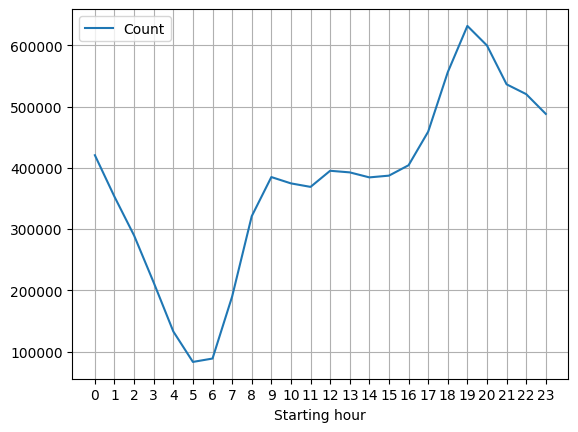

In [44]:
desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)
plt.xticks(np.arange(0,24,1))
plt.xlabel("Starting hour")

Text(0, 0.5, 'Idle time [minutes]')

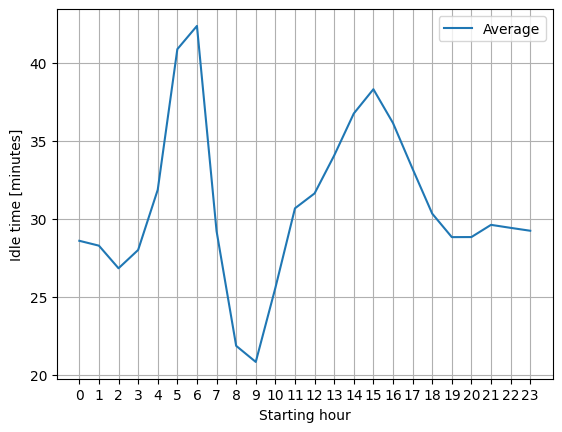

In [45]:
desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
plt.xticks(np.arange(0,24,1))
plt.xlabel("Starting hour")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

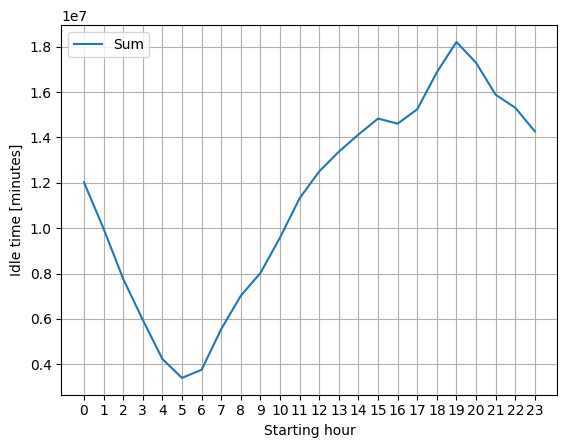

In [46]:
desc.descr_stat(df, columns=["start_time_hourly", "Idle Time Minutes"], group_by=["start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)
plt.xticks(np.arange(0,24,1))
plt.xlabel("Starting hour")
plt.ylabel("Idle time [minutes]")

#### Day Bin size

In [47]:
df['Day_Ordered'] = pd.Categorical(df['dayOfWeek'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Text(0, 0.5, 'Idle time [minutes]')

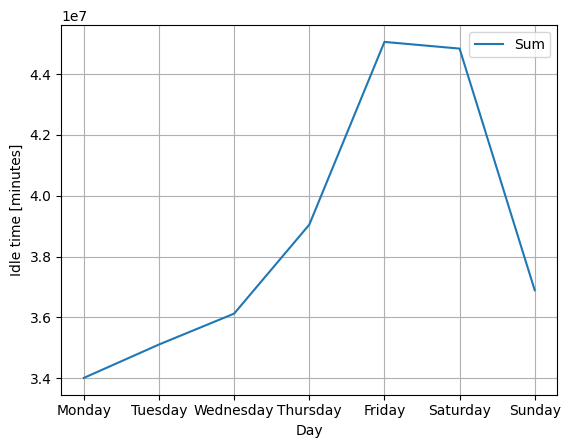

In [48]:
#How many idle time do we have by grouping days in total
desc.descr_stat(df, columns=["Day_Ordered", "Idle Time Minutes"], group_by=["Day_Ordered"], sort=True, sort_by=["Idle Time Minutes"], as_index=True, agg_mode="sum", plot=True)
plt.xlabel("Day")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

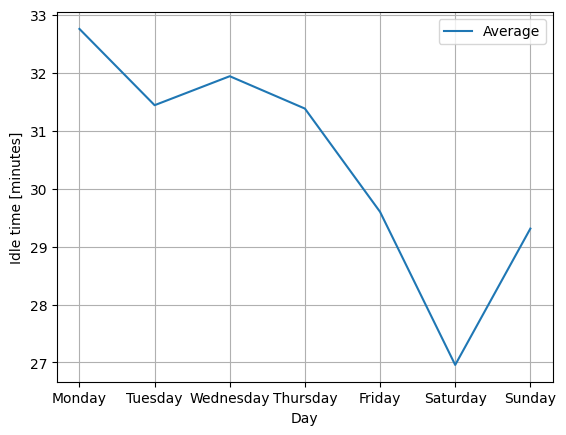

In [49]:
#How many idle time do we have by grouping days on average
desc.descr_stat(df, columns=["Day_Ordered", "Idle Time Minutes"], group_by=["Day_Ordered"], sort=True, sort_by=["Idle Time Minutes"], as_index=True, agg_mode="mean", plot=True)
plt.xlabel("Day")
plt.ylabel("Idle time [minutes]")

Text(0.5, 0, 'Day')

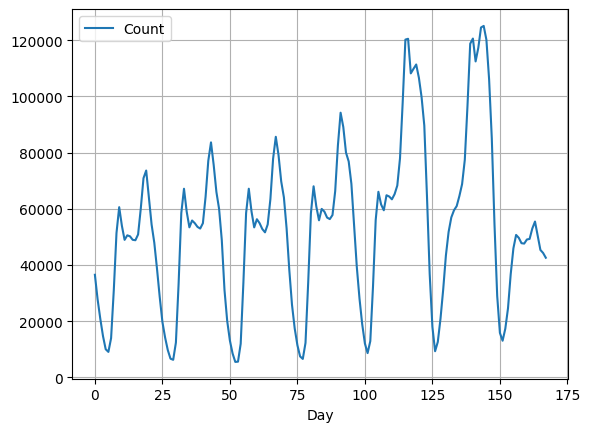

In [50]:
#how many data points for day + hour combination do we have
desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)
plt.xlabel("Day")

Text(0, 0.5, 'Idle time [minutes]')

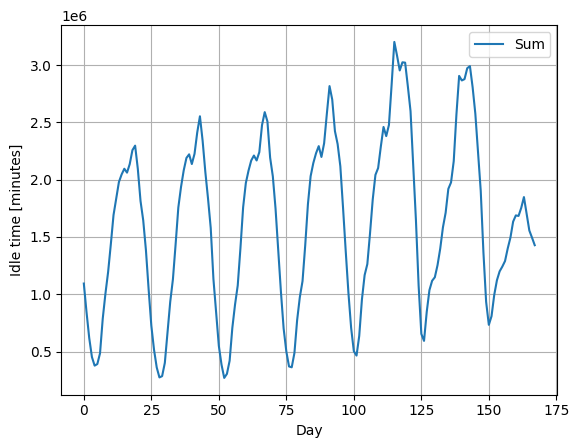

In [51]:
#How many idle time do we have by grouping days and starting hour together
desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)
plt.xlabel("Day")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

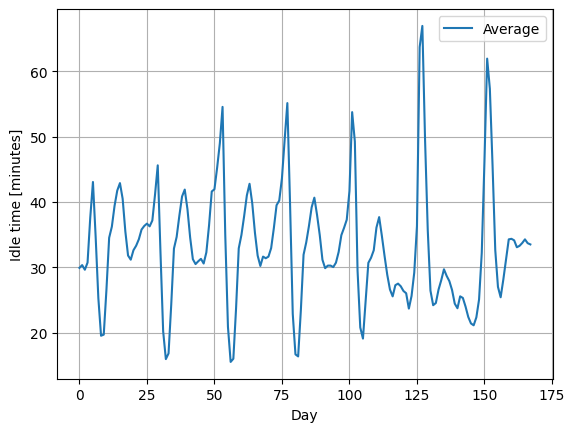

In [52]:
#How many idle time do we have on average by grouping days and starting hour together
desc.descr_stat(df, columns=["Day_Ordered", "start_time_hourly", "Idle Time Minutes"], group_by=["Day_Ordered", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
plt.xlabel("Day")
plt.ylabel("Idle time [minutes]")

#### Week bin size

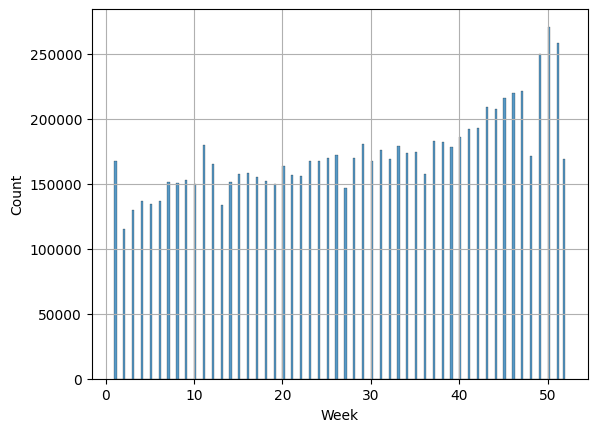

In [53]:
sns.histplot(df["start_time_week"])
plt.xlabel("Week")
plt.grid()

Text(0.5, 0, 'Week')

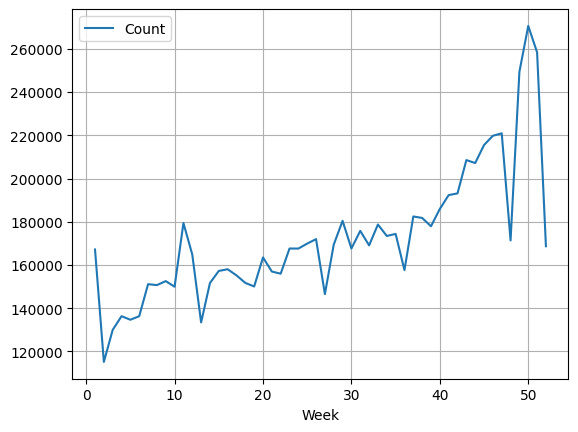

In [54]:
#how many datapoints do we have grouped by the week
desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="count", plot=True)
plt.xlabel("Week")

Text(0, 0.5, 'Idle time [minutes]')

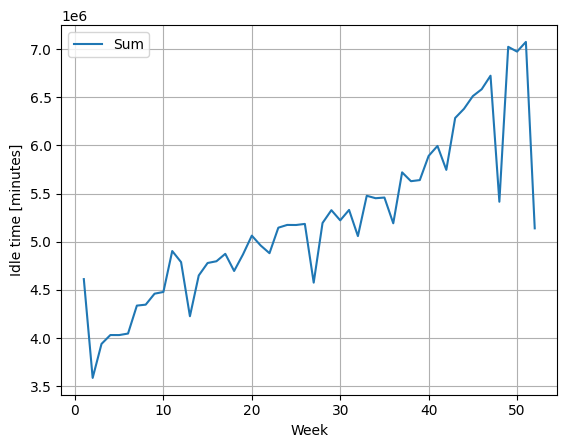

In [55]:
#how many idle time do we have grouped by the week in total
desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="sum", plot=True)
plt.xlabel("Week")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

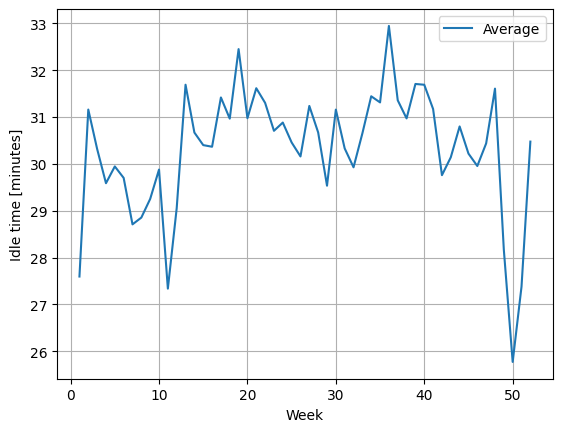

In [56]:
#how many idle time do we have grouped by the week on average
desc.descr_stat(df, columns=["start_time_week", "Idle Time Minutes"], group_by=["start_time_week"], sort=True, sort_by=["start_time_week"], agg_mode="mean", plot=True)
plt.xlabel("Week")
plt.ylabel("Idle time [minutes]")

Text(0.5, 0, 'Week')

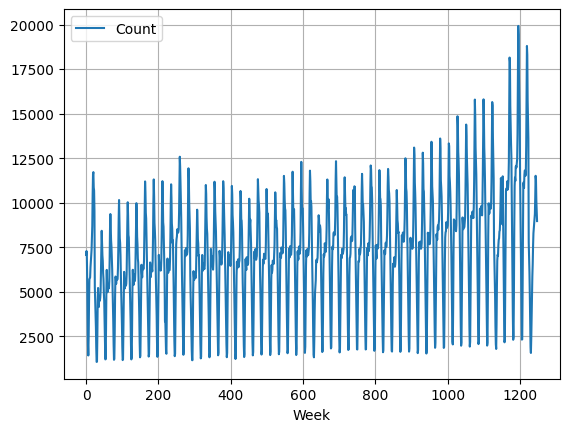

In [57]:
#how many datapoints do we have when grouping by week and hour
desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["start_time_week", "start_time_hourly"], as_index=False, agg_mode="count", plot=True)
plt.xlabel("Week")

Text(0, 0.5, 'Idle time [minutes]')

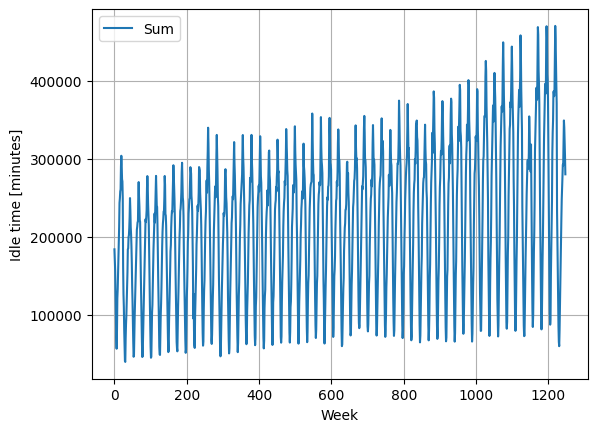

In [58]:
#how many idle time do we have grouped by the week and hour in total
desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["start_time_week", "start_time_hourly"], as_index=False, agg_mode="sum", plot=True)
plt.xlabel("Week")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

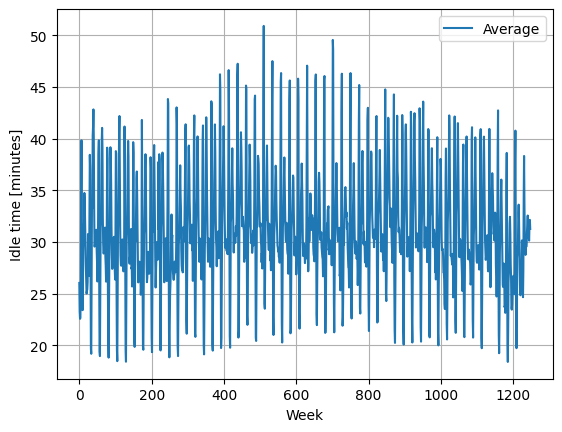

In [59]:
#how many idle time do we have grouped by the week and hour on average
desc.descr_stat(df, columns=["start_time_week", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_week", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
plt.xlabel("Week")
plt.ylabel("Idle time [minutes]")

#### Month bin size

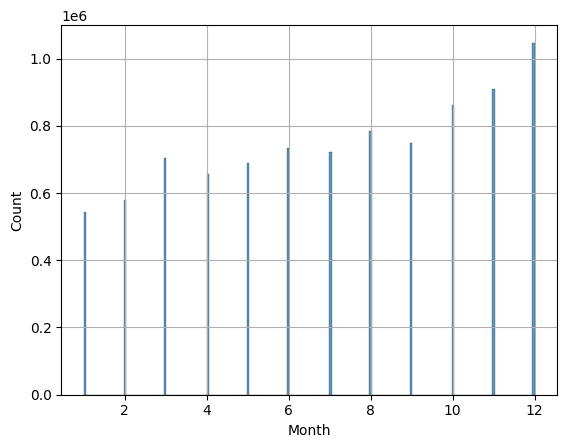

In [60]:
sns.histplot(df["start_time_month"])
plt.xlabel("Month")
plt.grid()

Text(0.5, 0, 'Month')

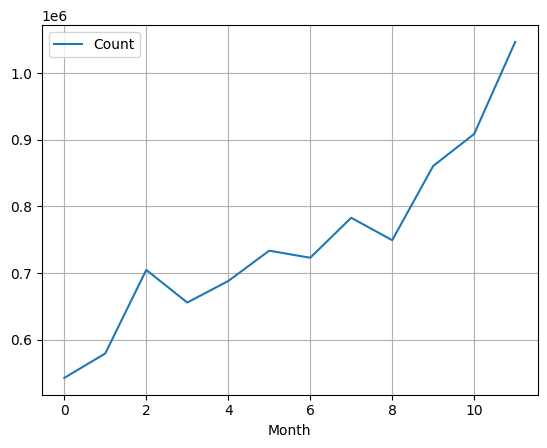

In [61]:
#how many datapoints do we have when grouping by month
desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)
plt.xlabel("Month")

Text(0, 0.5, 'Idle time [minutes]')

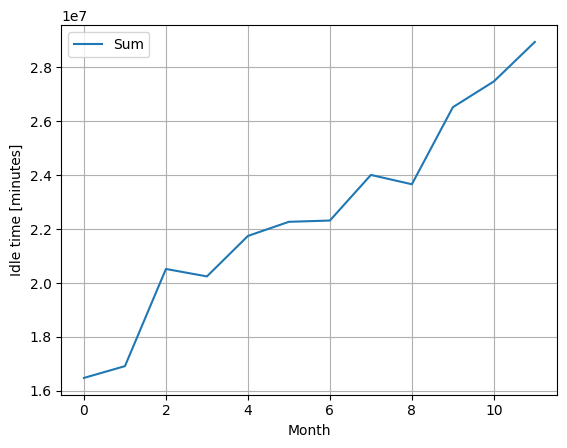

In [62]:
#how many idle time do we have grouped by the month in total
desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)
plt.xlabel("Month")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

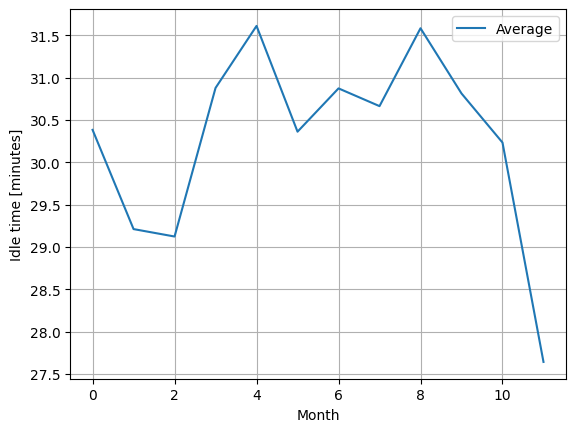

In [63]:
#how many idle time do we have grouped by the month on average
desc.descr_stat(df, columns=["start_time_month", "Idle Time Minutes"], group_by=["start_time_month"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
plt.xlabel("Month")
plt.ylabel("Idle time [minutes]")

Text(0.5, 0, 'Month')

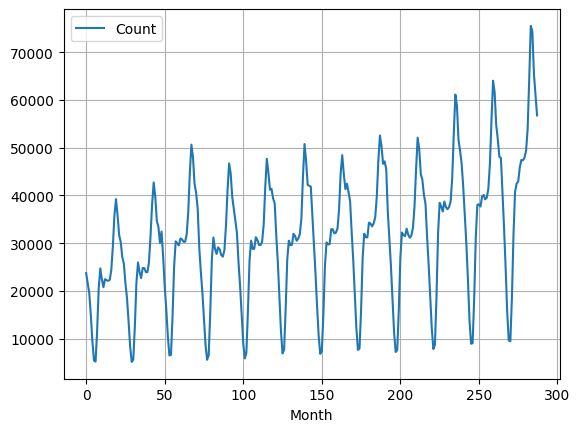

In [64]:
#how many datapoints do we have grouped by the month
desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="count", plot=True)
plt.xlabel("Month")

Text(0, 0.5, 'Idle time [minutes]')

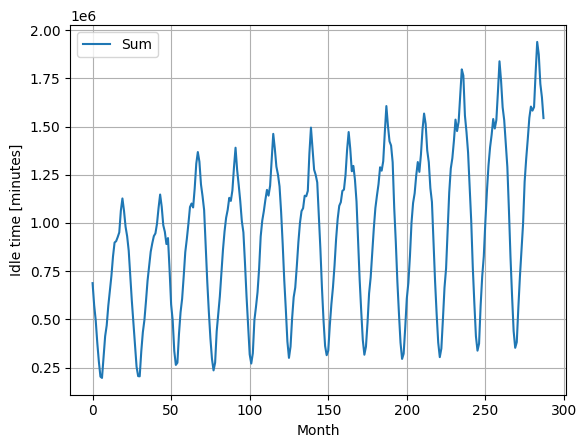

In [65]:
#how many idle time do we have grouped by the month and hour in total
desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="sum", plot=True)
plt.xlabel("Month")
plt.ylabel("Idle time [minutes]")

Text(0, 0.5, 'Idle time [minutes]')

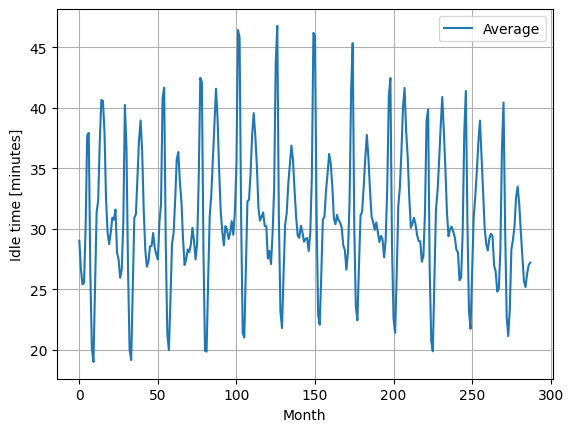

In [66]:
#how many idle time do we have grouped by the month and hour on average
desc.descr_stat(df, columns=["start_time_month", "start_time_hourly", "Idle Time Minutes"], group_by=["start_time_month", "start_time_hourly"], sort=True, sort_by=["Idle Time Minutes"], as_index=False, agg_mode="mean", plot=True)
plt.xlabel("Month")
plt.ylabel("Idle time [minutes]")